# Spin Classification Model

A deep learning model to classify quantum spin configurations

In [208]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [231]:
#define lattice size
L = 4

### Loading Datasets

You can load different datasets by changing the dataset path for testing, trainging, and benchmarking

In [232]:
# Set these variables to the appropriate directory paths

test_dir = "../data/{}-{}/binary_class/test/".format(L,L)
train_dir = "../data/{}-{}/binary_class/train/".format(L,L)

# Set these variables to the appropriate directory paths
benchmark_dir = "../data/{}-{}/temp_class/test/".format(L,L)

In [233]:
# data transforms
dset_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])

#create datasets using ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=dset_transform)
test_data = datasets.ImageFolder(test_dir, transform=dset_transform)
benchmark_data = datasets.ImageFolder(benchmark_dir, transform=dset_transform)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

## Architecture

This is the basic architecture of the model. The following parameters can be set:

* `input_size`: The dimensions of the input images.
* `hidden_layers`: The number of hidden layers in the model. Default: 5
* `layer_size`: The size of each hidden layer. Default: 128
* `conv`: Boolean to determine if the network should be fully connected or convolutional. Default: False
* `num_classes`: The number of output classes. Leave as 2 for binary classification. Otherwise set to number of temperature values for which data is available. Default: 2


In [234]:
input_size = [L,L]
hidden_layers = 4
layer_size = 128
conv = False # True for convolutional, False for fully connected
num_classes = 2

In [235]:
def linear_block(layer_size, num_layers):
    layers = []
    for i in range(num_layers):
        layers.append(nn.Linear(layer_size, layer_size))
        layers.append(nn.ReLU())
    return layers
    

In [236]:
def conv_block(layer_size, num_layers):
    layers = []
    for i in range(num_layers):
        layers.append(nn.Conv2d(layer_size, layer_size, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm2d(layer_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
    return layers

In [237]:
class SpinClassifier(nn.Module): 
    def __init__(self, input_size, hidden_layers, layer_size, num_classes, conv):
        super(SpinClassifier, self).__init__()
        self.conv = conv
        self.input_size = input_size
        self.input_dim = np.prod(input_size)
        self.output_dim = num_classes
        self.num_layers = hidden_layers
        self.layer_size = layer_size
        
        if self.conv:
            self.input_layer = [nn.Conv2d(1, self.layer_size, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)]
            self.output_layer = [nn.Conv2d(self.layer_size, self.output_dim, kernel_size=3, stride=1, padding=1), 
                                 nn.ReLU(), 
                                 nn.MaxPool2d(kernel_size=2, stride=2),
                                 nn.Flatten(),
                                 nn.Linear(self.output_dim * (self.input_size[0]//4) * (self.input_size[1]//4), self.layer_size), # 4 is the number of maxpooling layers
                                 nn.ReLU(),
                                 nn.Linear(self.layer_size, self.output_dim)] 
            self.layers = conv_block(self.layer_size, self.num_layers)
        else:
            self.input_layer = [nn.Linear(self.input_dim, self.layer_size), nn.ReLU()]
            self.output_layer = [nn.Linear(self.layer_size, self.output_dim)]
            self.layers = linear_block(self.layer_size, self.num_layers)
        
        self.model = nn.Sequential(*self.input_layer, *self.layers, *self.output_layer)


        
    def forward(self, x):
        if not self.conv:
            x = x.view(-1, self.input_dim)
        x = self.model(x)
        return x
            
        

Now we can set up the model and the training

In [238]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [239]:
model = SpinClassifier(input_size, hidden_layers, layer_size, num_classes, conv).to(DEVICE)

max_epochs = 75
criterion = nn.CrossEntropyLoss()
if conv:
    lr = 0.0001
else:
    lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

save_path = './models/Spin_Classifier.pt'
save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}

### Training the model

In [240]:
train_loss_history = []
test_loss_history = []

for epoch in range(max_epochs):

    train_loss = 0.0
    test_loss = 0.0

    for i, data in enumerate(train_loader):

        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        predicted_output = model(images)
        # print(predicted_output.shape)
        fit = criterion(predicted_output, labels)
        fit.backward()
        optimizer.step()
        train_loss += fit.item() / len(train_data)

    for i, data in enumerate(test_loader):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        predicted_output = model(images)
        fit = criterion(predicted_output, labels)
        test_loss += fit.item() / len(test_data)

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

    print(f'Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}')

Epoch: 0, Train Loss: 0.00767308177381027, Test Loss: 0.005742897155081355
Epoch: 1, Train Loss: 0.0054423267121722066, Test Loss: 0.005531112286375791
Epoch: 2, Train Loss: 0.005424344724998242, Test Loss: 0.005262463074631808
Epoch: 3, Train Loss: 0.0053833704823400925, Test Loss: 0.005163964837244373
Epoch: 4, Train Loss: 0.005246529372000112, Test Loss: 0.005240903144202582
Epoch: 5, Train Loss: 0.005204268466772101, Test Loss: 0.0052245612878625
Epoch: 6, Train Loss: 0.00532594224665223, Test Loss: 0.005114175956241967
Epoch: 7, Train Loss: 0.005160293099356861, Test Loss: 0.00515697424186439
Epoch: 8, Train Loss: 0.005151614201505011, Test Loss: 0.005243249782701818
Epoch: 9, Train Loss: 0.005130597363884855, Test Loss: 0.005012182123141317
Epoch: 10, Train Loss: 0.00520654791375486, Test Loss: 0.004956734304021043
Epoch: 11, Train Loss: 0.005192740999343917, Test Loss: 0.005004234868215349
Epoch: 12, Train Loss: 0.00507972004391798, Test Loss: 0.004898174543206285
Epoch: 13, Tra

Now we can plot our loss to see how the model improved over time

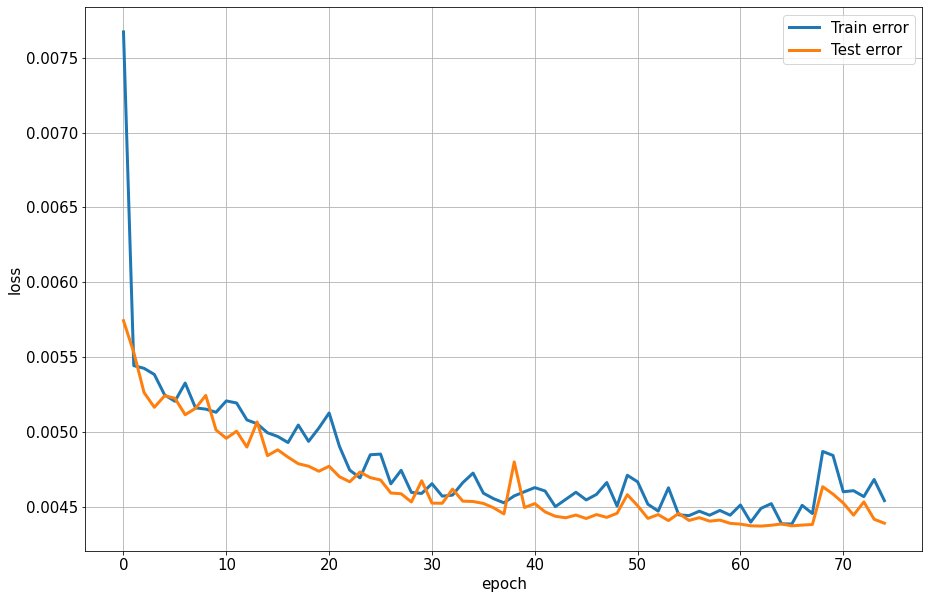

In [241]:

plt.rcParams.update({'font.size': 15})

fig, axes = plt.subplots(figsize=(15,10))
axes.plot(range(max_epochs),train_loss_history,'-',linewidth=3,label='Train error')
axes.plot(range(max_epochs),test_loss_history,'-',linewidth=3,label='Test error')
axes.set_xlabel('epoch')
axes.set_ylabel('loss')
axes.grid(True)
axes.legend()

plt.show()

In [242]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
fig.savefig('./results/loss.pdf', format='pdf')

## Plotting our Results

/tmp/ipykernel_1232840/3579682576.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_output = torch.nn.functional.softmax(predicted_output).cpu().detach().numpy()


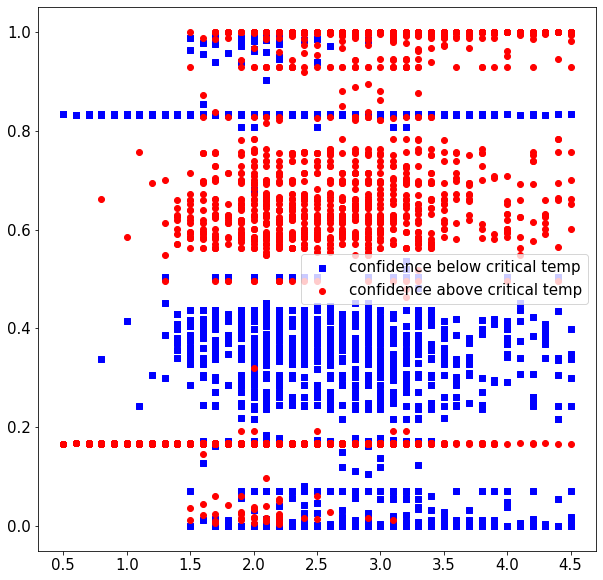

In [243]:
temp_pred_below = []
temp_pred_above = []
for idx in range(len(benchmark_data)):
  image, label = benchmark_data[idx]
  image = image.to(DEVICE)
  predicted_output = model(image.unsqueeze(0))
  
  # Need to apply softmax to get probabilities
  prob_output = torch.nn.functional.softmax(predicted_output).cpu().detach().numpy()
  predicted_label = torch.argmax(predicted_output).item()
  # print(f"predicted label: {predicted_label}, actual label: {label}")

  #get temp from label
  temp = benchmark_data.classes[label]
  temp_pred_below.append([float(temp), prob_output[0][1]])
  temp_pred_above.append([float(temp), prob_output[0][0]])

#plot the data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter([x[0] for x in temp_pred_below], [x[1] for x in temp_pred_below], c='b', marker="s", label='confidence below critical temp')
ax.scatter([x[0] for x in temp_pred_above], [x[1] for x in temp_pred_above], c='r', marker="o", label='confidence above critical temp')

plt.legend();
plt.show()


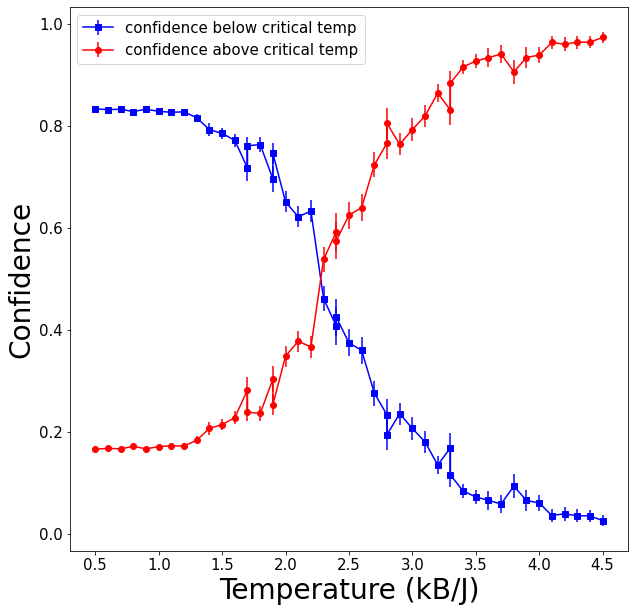

In [244]:
#plot the average confidence for each temperature with error bars
#error bars are standard deviation devide by sqrt of number of samples


# get the average & standard deviation of confidence for each temperature
temp_pred_below_avg = {}
temp_pred_above_avg = {}

temp_pred_below_std = {}
temp_pred_above_std = {}

for temp, pred in temp_pred_below:
    if temp in temp_pred_below_avg:
        temp_pred_below_avg[temp].append(pred)
    else:
        temp_pred_below_avg[temp] = [pred]

    if temp in temp_pred_below_std:
        temp_pred_below_std[temp].append(pred)
    else:
        temp_pred_below_std[temp] = [pred]

for temp, pred in temp_pred_above:
    if temp in temp_pred_above_avg:
        temp_pred_above_avg[temp].append(pred)
    else:
        temp_pred_above_avg[temp] = [pred]

    if temp in temp_pred_above_std:
        temp_pred_above_std[temp].append(pred)
    else:
        temp_pred_above_std[temp] = [pred]

temp_pred_above_avg = {temp: np.mean(pred) for temp, pred in temp_pred_above_avg.items()}
temp_pred_below_avg = {temp: np.mean(pred) for temp, pred in temp_pred_below_avg.items()}

temp_pred_above_err = {temp: np.std(pred)/np.sqrt(len(pred)) for temp, pred in temp_pred_above_std.items()}
temp_pred_below_err = {temp: np.std(pred)/np.sqrt(len(pred)) for temp, pred in temp_pred_below_std.items()}

    
#plot the data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.errorbar(list(temp_pred_below_avg.keys()), list(temp_pred_below_avg.values()), yerr=list(temp_pred_below_err.values()), c='b', marker="s", label='confidence below critical temp')
ax.errorbar(list(temp_pred_above_avg.keys()), list(temp_pred_above_avg.values()), yerr=list(temp_pred_above_err.values()), c='r', marker="o", label='confidence above critical temp')
#label the axes
plt.xlabel('Temperature ({unit})'.format(r'$k_BT/J$'), fontsize=28)
plt.ylabel('Confidence', fontsize=28)

plt.legend();
plt.show()
    

In [245]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
fig.savefig('./results/Spin_Classifier.pdf', format='pdf')

### Save the model

In [246]:
torch.save(model, './models/{}-{}-CNN.pth'.format(L,L))

# Comparing Different Models

In [247]:
# load datasets from the folder
data_dir = '../data/'
image_sizes = ['4-4', '8-8', '16-16', '25-25', '32-32']
dirs = [data_dir + size + '/temp_class/test/' for size in image_sizes]

# define the transforms
dset_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])

# load the datasets
dsets = {}
for i in range(len(dirs)):
    dsets[image_sizes[i]] = datasets.ImageFolder(dirs[i], transform=dset_transform)


In [248]:
model_dir = 'models/'
model_names = [size + '-NN.pth' for size in image_sizes]
model_paths = [model_dir + name for name in model_names]
models = {}

# load the models
for i in range(len(model_paths)):

    dummy_model = torch.load(model_paths[i])
    dummy_model.eval()
    models[image_sizes[i]] = dummy_model
    

### Visualizing the Performance of Different Models

First we define some helper functions to format the data

In [249]:
def get_predictions(model, data):
    temp_pred_below = []
    temp_pred_above = []
    model.eval()
    for idx in range(len(data)):
        image, label = data[idx]
        predicted_output = model(image.unsqueeze(0))

        # Need to apply softmax to get probabilities
        prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()
        predicted_label = torch.argmax(predicted_output).item()
        # print(f"predicted label: {predicted_label}, actual label: {label}")

        #get temp from label
        temp = data.classes[label]
        temp_pred_below.append([float(temp), prob_output[0][1]])
        temp_pred_above.append([float(temp), prob_output[0][0]])
    
    return temp_pred_below, temp_pred_above

In [250]:
def get_avg_err(temp_pred):
    temp_pred_avg = {}

    temp_pred_std = {}

    for temp, pred in temp_pred:
        if temp in temp_pred_avg:
            temp_pred_avg[temp].append(pred)
        else:
            temp_pred_avg[temp] = [pred]

        if temp in temp_pred_std:
            temp_pred_std[temp].append(pred)
        else:
            temp_pred_std[temp] = [pred]


    temp_pred_avg = {temp: np.mean(pred) for temp, pred in temp_pred_avg.items()}

    temp_pred_err = {temp: np.std(pred) for temp, pred in temp_pred_std.items()}

    return temp_pred_avg, temp_pred_err

/tmp/ipykernel_1232840/1458513661.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()


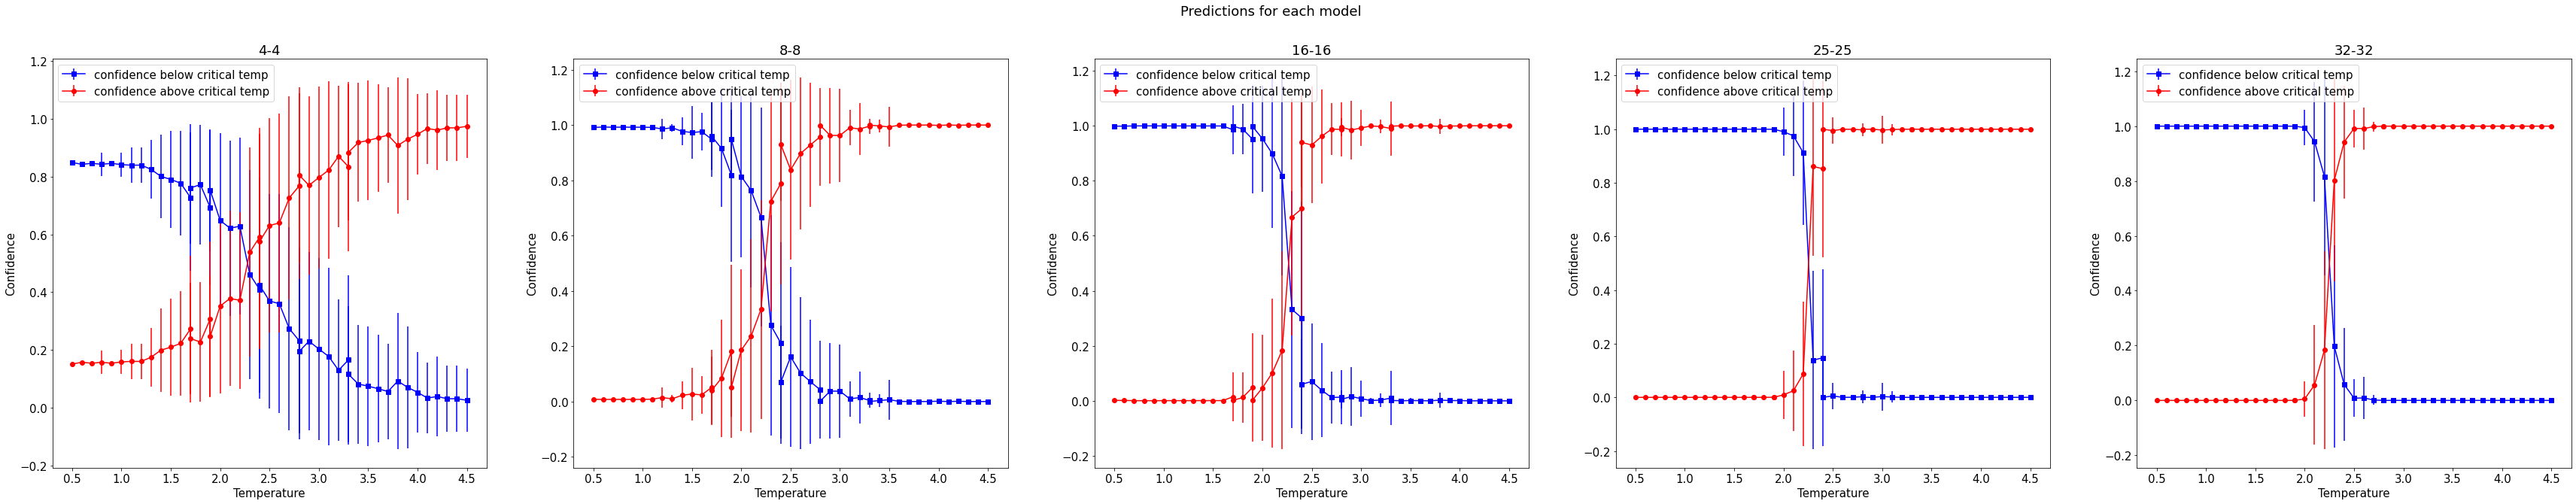

In [251]:
# get predictions for each model
import matplotlib 

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 32}
temp_pred = {y: get_predictions(models[y], dsets[y]) for y in image_sizes}

figure, axes = plt.subplots(1, 5, figsize=(60, 10))
figure.suptitle('Predictions for each model')

#get the average and error for each model and plot it
for i, size in enumerate(image_sizes):
    temp_pred_below_avg, temp_pred_below_err = get_avg_err(temp_pred[size][0])
    temp_pred_above_avg, temp_pred_above_err = get_avg_err(temp_pred[size][1])

    axes[i].errorbar(list(temp_pred_below_avg.keys()), list(temp_pred_below_avg.values()), yerr=list(temp_pred_below_err.values()), c='b', marker="s", label='confidence below critical temp')
    axes[i].errorbar(list(temp_pred_above_avg.keys()), list(temp_pred_above_avg.values()), yerr=list(temp_pred_above_err.values()), c='r', marker="o", label='confidence above critical temp')
    axes[i].set_title(size)
    axes[i].set_xlabel('Temperature')
    axes[i].set_ylabel('Confidence')
    axes[i].legend(loc='upper left')

plt.show()

In [252]:
matplotlib.rcParams['pdf.fonttype'] = 42
figure.savefig('./results/Comparison.pdf', format='pdf')